# Prepare Circuits

In [1]:
%load_ext autoreload
%autoreload 2

In [221]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter, Instruction

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
from qiskit.opflow import Zero, One, I, X, Y, Z

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy
import itertools

import seaborn as sns

In [222]:
def gen_trott_gate():
    t = Parameter('t') # parameterize variable t
    
    # XX(t)
    XX_qr = QuantumRegister(2)
    XX_qc = QuantumCircuit(XX_qr, name='XX')

    XX_qc.ry(np.pi/2,[0,1])
    XX_qc.cnot(0,1)
    XX_qc.rz(2 * t, 1)
    XX_qc.cnot(0,1)
    XX_qc.ry(-np.pi/2,[0,1])

    # Convert custom quantum circuit into a gate
    XX = XX_qc.to_instruction()
    
    # YY(t)
    YY_qr = QuantumRegister(2)
    YY_qc = QuantumCircuit(YY_qr, name='YY')

    YY_qc.rx(np.pi/2,[0,1])
    YY_qc.cnot(0,1)
    YY_qc.rz(2 * t, 1)
    YY_qc.cnot(0,1)
    YY_qc.rx(-np.pi/2,[0,1])

    # Convert custom quantum circuit into a gate
    YY = YY_qc.to_instruction()

        
    # ZZ(t)
    ZZ_qr = QuantumRegister(2)
    ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

    ZZ_qc.cnot(0,1)
    ZZ_qc.rz(2 * t, 1)
    ZZ_qc.cnot(0,1)

    # Convert custom quantum circuit into a gate
    ZZ = ZZ_qc.to_instruction()
    
    num_qubits = 3

    Trott_qr = QuantumRegister(num_qubits)
    Trott_qc = QuantumCircuit(Trott_qr, name='Trot')

    for i in range(0, num_qubits - 1):
        Trott_qc.append(ZZ, [Trott_qr[i], Trott_qr[i+1]])
        Trott_qc.append(YY, [Trott_qr[i], Trott_qr[i+1]])
        Trott_qc.append(XX, [Trott_qr[i], Trott_qr[i+1]])

    # Convert custom quantum circuit into a gate
    Trott_gate = Trott_qc.to_instruction()
    return Trott_gate

In [223]:
def gen_qcs(trott_gate: Instruction, trotter_steps: int):
    """
    Args:
        n (int): number of trotter steps
    """
    
    t = trott_gate.params[0] # assuming only t param
    
    target_time = np.pi
    
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    
    qc.x([3,5]) # prepare init state |q5q3q1> = |110>
    
    
    # Create dummy circuit
    qc_dummy = QuantumCircuit(qr)
    
    for _ in range(trotter_steps):
        qc_dummy.append(trott_gate, [qr[1], qr[3], qr[5]])
    
    # Decompose dummy circuit into native gates and append to qc
    qc = qc + qc_dummy.decompose().decompose()
    
    # Bind timestep parameter
    qc = qc.bind_parameters({t: target_time/trotter_steps})
    
    # Generate tomography circuits
    st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])
    
    return st_qcs

In [224]:
trott_steps_range = np.arange(4,15,1)
trott_gate = gen_trott_gate() # using the basic trott method (this can be changed)

qcs = {}
for trott_steps_val in trott_steps_range:
    qcs[trott_steps_val] = gen_qcs(trott_gate, trott_steps_val)

In [225]:
qcs[10][-2].draw() # e.g. 10 trott steps, example tomo circuit

»
q8649_0: ──────────────────────────────────────────────────────────────────────»
                                   ┌─────────┐                     ┌──────────┐»
q8649_1: ───────■───────────────■──┤ Rx(π/2) ├──■───────────────■──┤ Rx(-π/2) ├»
                │               │  └─────────┘  │               │  └──────────┘»
q8649_2: ───────┼───────────────┼───────────────┼───────────────┼──────────────»
         ┌───┐┌─┴─┐┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐┌──────────┐»
q8649_3: ┤ X ├┤ X ├┤ Rz(π/5) ├┤ X ├┤ Rx(π/2) ├┤ X ├┤ Rz(π/5) ├┤ X ├┤ Rx(-π/2) ├»
         └───┘└───┘└─────────┘└───┘└─────────┘└───┘└─────────┘└───┘└──────────┘»
q8649_4: ──────────────────────────────────────────────────────────────────────»
         ┌───┐                                                                 »
q8649_5: ┤ X ├─────────────────────────────────────────────────────────────────»
         └───┘                                                                 »
q8649_6: ──────────────────────────────────────────────────────────────────────»
                                                                               »
  c18: 3/══════════════════════════════════════════════════════════════════════»
                                                                               »
«                                                                          »
«q8649_0: ─────────────────────────────────────────────────────────────────»
«         ┌─────────┐                     ┌──────────┐                     »
«q8649_1: ┤ Ry(π/2) ├──■───────────────■──┤ Ry(-π/2) ├─────────────────────»
«         └─────────┘  │               │  └──────────┘                     »
«q8649_2: ─────────────┼───────────────┼───────────────────────────────────»
«         ┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐┌──────────┐                     »
«q8649_3: ┤ Ry(π/2) ├┤ X ├┤ Rz(π/5) ├┤ X ├┤ Ry(-π/2) ├──■───────────────■──»
«         └─────────┘└───┘└─────────┘└───┘└──────────┘  │               │  »
«q8649_4: ──────────────────────────────────────────────┼───────────────┼──»
«                                                     ┌─┴─┐┌─────────┐┌─┴─┐»
«q8649_5: ────────────────────────────────────────────┤ X ├┤ Rz(π/5) ├┤ X ├»
«                                                     └───┘└─────────┘└───┘»
«q8649_6: ─────────────────────────────────────────────────────────────────»
«                                                                          »
«  c18: 3/═════════════════════════════════════════════════════════════════»
«                                                                          »
«                                                                     »
«q8649_0: ────────────────────────────────────────────────────────────»
«                                                                     »
«q8649_1: ────────────────────────────────────────────────────────────»
«                                                                     »
«q8649_2: ────────────────────────────────────────────────────────────»
«         ┌─────────┐                     ┌──────────┐┌─────────┐     »
«q8649_3: ┤ Rx(π/2) ├──■───────────────■──┤ Rx(-π/2) ├┤ Ry(π/2) ├──■──»
«         └─────────┘  │               │  └──────────┘└─────────┘  │  »
«q8649_4: ─────────────┼───────────────┼───────────────────────────┼──»
«         ┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐┌──────────┐┌─────────┐┌─┴─┐»
«q8649_5: ┤ Rx(π/2) ├┤ X ├┤ Rz(π/5) ├┤ X ├┤ Rx(-π/2) ├┤ Ry(π/2) ├┤ X ├»
«         └─────────┘└───┘└─────────┘└───┘└──────────┘└─────────┘└───┘»
«q8649_6: ────────────────────────────────────────────────────────────»
«                                                                     »
«  c18: 3/════════════════════════════════════════════════════════════»
«                                                                     »
«                                                                          »
«q8649_0: ─────────────────────────────────────────────────────────────────»
«              

# Prepare Target State

In [226]:
import qutip as qt
g = qt.basis(2,0)
e = qt.basis(2,1)

# fidelity: the reconstructed state has the (flipped) ordering |q5q3q1> 
target_state_qt = qt.tensor(e,e,g)
target_state_qt = qt.ket2dm(target_state_qt)
target_state = target_state_qt.full()


# parity: "XYZ" corresponds to X measurement on q1, Y measurement on q3, and Z measurement on q5
target_state_parity_qt = qt.ket2dm( qt.tensor(g,e,e))
target_state_parity = target_state_parity_qt.full()

In [227]:
pauli = {"X":qt.sigmax(),"Y":qt.sigmay(),"Z":qt.sigmaz(),"I":qt.identity(2)}
target_parity = {}
for k1, p1 in pauli.items():
    for k2, p2 in pauli.items():
        for k3, p3 in pauli.items():
            pauli_string = k1+k2+k3
            if pauli_string == "III":
                continue
            op = qt.tensor(p1,p2,p3)
            meas = (target_state_parity_qt*op).tr()
            target_parity[pauli_string] = meas

In [228]:
target_parity

{'XXX': 0.0,
 'XXY': 0.0,
 'XXZ': 0.0,
 'XXI': 0.0,
 'XYX': 0.0,
 'XYY': 0.0,
 'XYZ': 0.0,
 'XYI': 0.0,
 'XZX': 0.0,
 'XZY': 0.0,
 'XZZ': 0.0,
 'XZI': 0.0,
 'XIX': 0.0,
 'XIY': 0.0,
 'XIZ': 0.0,
 'XII': 0.0,
 'YXX': 0.0,
 'YXY': 0.0,
 'YXZ': 0.0,
 'YXI': 0.0,
 'YYX': 0.0,
 'YYY': 0.0,
 'YYZ': 0.0,
 'YYI': 0.0,
 'YZX': 0.0,
 'YZY': 0.0,
 'YZZ': 0.0,
 'YZI': 0.0,
 'YIX': 0.0,
 'YIY': 0.0,
 'YIZ': 0.0,
 'YII': 0.0,
 'ZXX': 0.0,
 'ZXY': 0.0,
 'ZXZ': 0.0,
 'ZXI': 0.0,
 'ZYX': 0.0,
 'ZYY': 0.0,
 'ZYZ': 0.0,
 'ZYI': 0.0,
 'ZZX': 0.0,
 'ZZY': 0.0,
 'ZZZ': 1.0,
 'ZZI': -1.0,
 'ZIX': 0.0,
 'ZIY': 0.0,
 'ZIZ': -1.0,
 'ZII': 1.0,
 'IXX': 0.0,
 'IXY': 0.0,
 'IXZ': 0.0,
 'IXI': 0.0,
 'IYX': 0.0,
 'IYY': 0.0,
 'IYZ': 0.0,
 'IYI': 0.0,
 'IZX': 0.0,
 'IZY': 0.0,
 'IZZ': 1.0,
 'IZI': -1.0,
 'IIX': 0.0,
 'IIY': 0.0,
 'IIZ': -1.0}

# Results

In [230]:
# load IBMQ Account data'

#TOKEN = "8aff106b0ae4aacfcfcd91148acea1a33560096c9caf3cfbfff540c4dc0758781ea988bf304772bb82622b73547280dcaa71e827099d1e272b6dc600bdbb8a08"
#IBMQ.save_account(TOKEN)  # replace TOKEN with your API token string (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)
provider = IBMQ.load_account()

In [231]:
# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')
# properties = jakarta.properties()

# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

# Noiseless simulated backend
sim = QasmSimulator()

In [232]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    return rho_fit
    # fid = state_fidelity(rho_fit, target_state)
    # return fid

In [233]:
def gen_result_single(st_qcs, backend = sim):
    shots = 8192
    reps = 1 #TODO: change back to 8

    # create jobs
    jobs = []
    for _ in range(reps):
        # execute
        job = execute(st_qcs, backend, shots=shots)
        print('Job ID', job.job_id())
        jobs.append(job)
        
    # monitor jobs
    for job in jobs:
        job_monitor(job)
        try:
            if job.error_message() is not None:
                print(job.error_message())
        except:
            pass
    
    # calculate fids
    rhos = []
    raw_results = []
    for job in jobs:
        raw_results.append(job.result())
        rho = state_tomo(raw_results[-1], st_qcs)
        rhos.append(rho)
    
    return rhos, raw_results

def gen_results(qcs, backend = sim):
    results = {"properties": {"backend": backend}, "data":{}}
    # test = 2
    for num_trott_steps, st_qcs in tqdm(qcs.items()):
        print("="*20)
        print(f"Running with trott_steps = {num_trott_steps}")
        
        # if test <= 0:
        #     continue
        # test -= 1
        
        results["data"][num_trott_steps] = {}
        results["data"][num_trott_steps]["rhos"], results["data"][num_trott_steps]["raw_data"] = gen_result_single(st_qcs)
    return results

In [234]:
ACTIVE_LIST = [(1,1,1), (1,1,0), (1,0,1), (0,1,1), (1,0,0), (0,1,0), (0,0,1)] # [ZXY, ZXI, ZIY, IXY, ZII, IXI, IIY]

def extract_key(key):
    # e.g. "('Z', 'Z', 'X')" -> ZZX
    return key[2] + key[7] + key[12]

def add_dicts(a,b):
    c = {}
    keys = set(list(a.keys()) + list(b.keys())) # union of keys
    for key in keys:
        c[key] = a.get(key,0) + b.get(key, 0)
    return c

def calc_parity(pauli_string, readout_string, active_spots):
    """
    Args:
        b (str): e.g. '0x6'
        active_spots (List[int]): e.g. (1, 1, 0)
    """
    n = len(pauli_string)
    
    adjusted_pauli_string = ""
    for i in range(n):
        letter = pauli_string[i]
        adjusted_pauli_string += letter if active_spots[i] else "I"
        
    
    b = list(format(int(readout_string[2:]), '#05b')[2:]) # e.g. "0x6" -> ["1", "1", "0"]
    b = b[::-1] # ["1", "1", "0"] -> ["0", "1", "1"]
    v = np.array([1-int(val)*2 for val in b]) #  ["0", "1", "1"] ->  [1, -1, -1]
    active = v*np.array(active_spots) # [1, -1, -1] * [1, 1, 0] -> [1, -1, 0]
    p = np.prod(active[active!=0]) # [1,-1] -> (1)*(-1) = -1
    y = int((1-p)/2) #map: 1,-1 -> 0,1
    return adjusted_pauli_string, y

def run_analysis(results):
    results = copy.deepcopy(results)
    
    #data map
    num_qubits = 3
    parsed_data = {} # key: e.g. "XYZ", "XYI", .. | val: for each parity measurement (e.g. <XYI>) we store [counts of 1, counts of -1], e.g. [12345, 950] 
    for num_trott_steps, result in results["data"].items():
        data_map = {}
        reps = len(result["raw_data"])
        for i in range(3**num_qubits):  # loop over pauli strings (i.e. different tomography circuits)
            counts = {} # for each pauli string, we store total counts added together from each rep, e.g. {'0x6': 4014, '0x2': 4178}
            pauli_string = extract_key(result["raw_data"][0].results[i].header.name)
            for r in range(reps): # loop over reps
                counts = add_dicts(counts, result["raw_data"][r].results[i].data.counts) # adding counts together
            data_map[pauli_string] = counts
            
            for active_spots in ACTIVE_LIST: # Loops through all possible parity measurements, e.g. [ZXY, ZXI, ZIY, IXY, ZII, IXI, IIY]
                for readout_string, count in counts.items(): # loops through all readout values, e.g. '0x6', '0x2'
                    adjusted_pauli_string, parity_meas = calc_parity(pauli_string, readout_string, active_spots) # ("ZXY", "0x6", (1,1,0)) -> "ZXI", 1 corresponds to <ZXI> = -1 measurement
                    # if adjusted_pauli_string == "IIZ":
                    #     print(pauli_string, readout_string, active_spots, adjusted_pauli_string, parity_meas, count)
                    if adjusted_pauli_string not in parsed_data:
                        parsed_data[adjusted_pauli_string] = [0,0] # [counts of 1, counts of -1]
                    parsed_data[adjusted_pauli_string][parity_meas] += count

        result["data_map"] = data_map
        result["parsed_data"] = parsed_data
        
        parity = {} # key: e.g. "XYZ", "XYI", .. | val: for each parity measurement we store the expectation value (e.g. <XYI>)
        for parity_string, count in parsed_data.items():
            norm = np.sum(count)
            parity[parity_string] = (1)*count[0]/norm + (-1)*count[1]/norm # (1) * (counts of 1) + (-1)*(counts of -1) = <ZXY>
        
        result["parity"] = parity
        
    
    for num_trott_steps, result in results["data"].items():
        # calculate fids for each rep
        fids = []
        for rho in result["rhos"]:
            fids.append(state_fidelity(rho, target_state))
        fids = np.array(fids)
        result["infids"] = 1 - fids
        
        # calculate fid for avg rho
        result["avg_rho"] = np.mean(result["rhos"], axis=0)
        result["avg_infid"] =  1 - state_fidelity(result["avg_rho"], target_state)
        
        # calculate distance from |110><110| matrix element
        result["avg_element_dist"] = np.abs(target_state  - result["avg_rho"])
        
        result["avg_l1_dist"] = np.linalg.norm(target_state  - result["avg_rho"], ord=1)

    return results

In [235]:
def plot_metric(results, metric_func=None, plot_label="Infidelity", plot_log=True, axs=None, legend_label=None):
    metric_func = metric_func if metric_func is not None else lambda res: res["avg_infid"]
    steps = []
    metric = []
    for num_trott_steps, result in results["data"].items():
        steps.append(num_trott_steps)
        metric.append(metric_func(result))
    
    steps = np.array(steps)
    metric = np.array(metric)
    
    if axs is None:
        fig, axs = plt.subplots(2 if plot_log else 1,2, figsize=(8,6 if plot_log else 3), dpi=200, squeeze=False)
    
    ax = axs[0][0]
    ax.plot(1/steps, metric, label=legend_label)
    ax.set_xlabel("1/(# of Trotterization Steps)")
    ax.set_ylabel(plot_label)
    if legend_label is not None:
        ax.legend(fontsize=6)
    
    ax = axs[0][1]
    ax.plot(steps, metric, label=legend_label)
    ax.set_xlabel("(# of Trotterization Steps)")
    ax.set_ylabel(plot_label)
    if legend_label is not None:
        ax.legend(fontsize=6)
    
    if plot_log:
        ax = axs[1][0]
        ax.plot(1/steps, np.log(metric), label=legend_label)
        ax.set_xlabel("1/(# of Trotterization Steps)")
        ax.set_ylabel(f"log({plot_label})")
        if legend_label is not None:
            ax.legend(fontsize=6)

        ax = axs[1][1]
        ax.plot(steps, np.log(metric), label=legend_label)
        ax.set_xlabel("(# of Trotterization Steps)")
        ax.set_ylabel(f"log({plot_label})")
        if legend_label is not None:
            ax.legend(fontsize=6)
    
    fig = plt.gcf()
    fig.suptitle(f"{plot_label} vs. Trotterization Step #")
    
    fig.tight_layout()
    
    
    return axs

def plot_fidelities(results):
    return plot_metric(results, metric_func= lambda res: res["avg_infid"], plot_label="Infidelity")

def plot_element_dist(results, row=6, col=6):
    return plot_metric(results, metric_func= lambda res: res["avg_element_dist"][row][col], plot_label=f"Element Dist. ({row}, {col})")

def plot_l1_dist(results):
    return plot_metric(results, metric_func= lambda res: res["avg_l1_dist"], plot_label=f"L1 Dist.")

def plot_parity(results):
    parity_strings = list(list(results["data"].values())[0]["parity"].keys())
    
    axs = None
    for parity_string in parity_strings[1:]:
        axs = plot_metric(results, metric_func= lambda res: res["parity"][parity_string], plot_label=f"<Pauli String>", plot_log=False, axs=axs) #, legend_label=f"<{parity_string}>")
    
    return axs

def plot_parity_dist(results):
    parity_strings = list(list(results["data"].values())[0]["parity"].keys())
    axs = None
    for parity_string in parity_strings[1:]:
        axs = plot_metric(results, metric_func= lambda res: np.abs(target_parity[parity_string] - res["parity"][parity_string]), plot_label=f"|<Exp PStr> - <Meas PStr>|", plot_log=False, axs=axs) #, legend_label=f"<{parity_string}>")
    
    return axs

def parity2prob(parity_results, shots=1000, num_qubits=3, return_probs=False):
    paulis = ["X", "Y", "Z"]
    pauli_combos = list(itertools.product(*tuple([paulis for _ in range(num_qubits)])))
    pauli_combos = ["".join(x) for x in pauli_combos]
    
    make_bin = lambda j: np.array([int(x) for x in list(format(j, f'#0{num_qubits+2}b')[2:])])
    make_int = lambda b: [str(x) for x in b]
    readout_results = np.array([make_bin(j) for j in range(7,-1,-1)])
    active_spots = readout_results[:-1].copy()
    
    M_pexp_prob = np.zeros((2**num_qubits,2**num_qubits))
    
    for col, r in enumerate(readout_results):
        for row, a in enumerate(active_spots):
            parity = calc_parity(r,a)
            M_pexp_prob[row,col] = parity
    M_pexp_prob[-1,:] = np.ones_like(M_pexp_prob[-1,:]) # probability normalization
    M_prob_pexp = np.linalg.inv(M_pexp_prob)
    
    
    make_prob_label = lambda bs: "0x"+str(int("".join([str(b) for b in bs]),2))
    prob_results = {}
    for p in pauli_combos:
        # p_exp_labels: e.g. ['XYZ', 'XYI', 'XIZ', 'XII', 'IYZ', 'IYI', 'IIZ']
        p_exp_labels = [calc_adjusted_pauli_string(p,s) for s in active_spots]
        p_exp_vals = [parity_results[l] for l in p_exp_labels]
        p_exp_vals.append(1.0)
        p_exp_vals = np.array(p_exp_vals)
        probs = M_prob_pexp @ p_exp_vals
        
        if not return_probs:
            probs = [int(shots*x) for x in probs]
        
        # reverse order of readout to follow Qiskit convention: [1,1,0] -> [0,1,1]
        prob_results[p] = {make_prob_label(readout_results[i][::-1]):p_val for i, p_val in enumerate(probs)}
    return prob_results

## Noiseless Sims

#### Capture Data

In [236]:
results = gen_results(qcs, backend=sim)

  0%|                                                                        | 0/11 [00:00<?, ?it/s]

Running with trott_steps = 4
Job ID 3e6d4cb6-91ed-4bda-9a65-3459e816e5f2
Job Status: job is actively running

  9%|█████▊                                                          | 1/11 [00:06<01:05,  6.52s/it]

Job Status: job has successfully run
Running with trott_steps = 5
Job ID f527f297-0037-422f-935a-e110c7814c1e
Job Status: job is actively running

 18%|███████████▋                                                    | 2/11 [00:13<00:59,  6.59s/it]

Job Status: job has successfully run
Running with trott_steps = 6
Job ID 7eed9206-26e2-4c7f-bade-a14aea50f730
Job Status: job is actively running

 27%|█████████████████▍                                              | 3/11 [00:19<00:53,  6.70s/it]

Job Status: job has successfully run
Running with trott_steps = 7
Job ID c1a5836d-782b-4e92-aaea-3569c24f1679
Job Status: job is actively running

 36%|███████████████████████▎                                        | 4/11 [00:27<00:48,  6.86s/it]

Job Status: job has successfully run
Running with trott_steps = 8
Job ID 808c1b17-ecd5-453c-88e9-df03a46090d4
Job Status: job is actively running

 45%|█████████████████████████████                                   | 5/11 [00:34<00:42,  7.05s/it]

Job Status: job has successfully run
Running with trott_steps = 9
Job ID 7f8c015b-6fd5-4ae3-b5d0-f609c522d509
Job Status: job is actively running

 55%|██████████████████████████████████▉                             | 6/11 [00:42<00:36,  7.23s/it]

Job Status: job has successfully run
Running with trott_steps = 10
Job ID d2ed9680-b2aa-4594-82a5-15669382c3e3
Job Status: job is actively running

 64%|████████████████████████████████████████▋                       | 7/11 [00:49<00:29,  7.43s/it]

Job Status: job has successfully run
Running with trott_steps = 11
Job ID d69d4556-17b0-4e3c-84cb-40f67ffe0336
Job Status: job is actively running

 73%|██████████████████████████████████████████████▌                 | 8/11 [00:58<00:23,  7.70s/it]

Job Status: job has successfully run
Running with trott_steps = 12
Job ID 08a74dfe-5130-4302-97d2-8eff04117adb
Job Status: job is actively running

 82%|████████████████████████████████████████████████████▎           | 9/11 [01:06<00:15,  7.85s/it]

Job Status: job has successfully run
Running with trott_steps = 13
Job ID 536a3ca6-5f00-4335-bae0-ef531e8e1563
Job Status: job is actively running

 91%|█████████████████████████████████████████████████████████▎     | 10/11 [01:15<00:08,  8.10s/it]

Job Status: job has successfully run
Running with trott_steps = 14
Job ID 7f0d9262-6d77-4b43-bade-d73a18cb9fcd
Job Status: job is actively running

100%|███████████████████████████████████████████████████████████████| 11/11 [01:23<00:00,  7.63s/it]

Job Status: job has successfully run


#### Run Analysis

In [237]:
res_analysis = run_analysis(results) 

In [238]:
ps = ["ZZZ", "ZZI", "ZIZ", "IZZ", "ZII", "IZI", "IIZ"]
n = 11
for p in ps:
    print(p, target_parity[p], res_analysis["data"][n]["parity"][p], res_analysis["data"][n]["parsed_data"][p])

ZZZ 1.0 1.0 [90112, 0]
ZZI -1.0 -0.3925069173177083 [60922, 209414]
ZIZ -1.0 -0.9248046875 [7735, 262601]
IZZ 1.0 0.318084716796875 [201808, 68528]
ZII 1.0 0.3158128526475694 [604718, 206290]
IZI -1.0 -0.9233635796440973 [23680, 787328]
IIZ -1.0 -0.3906046549479167 [183122, 627886]


In [239]:
res_analysis["data"][5]["avg_infid"], np.mean(res_analysis["data"][5]["infids"]) # these should match

(0.740363556650929, 0.740363556650929)

# Tomography MLE

In [240]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter, Instruction
from qiskit.quantum_info import Pauli, DensityMatrix, Statevector, partial_trace

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography.fitters.lstsq_fit import lstsq_fit, make_positive_semidefinite
from qiskit.ignis.verification.tomography.fitters.cvx_fit import cvx_fit

from qiskit.quantum_info import state_fidelity
from qiskit.opflow import Zero, One, I, X, Y, Z

### Statevector

In [241]:
def gen_qc(trott_gate: Instruction, trotter_steps: int):
    """
    Args:
        n (int): number of trotter steps
    """
    
    t = trott_gate.params[0] # assuming only t param
    
    target_time = np.pi
    
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    
    qc.x([3,5]) # prepare init state |q5q3q1> = |110>
    
    
    # Create dummy circuit
    qc_dummy = QuantumCircuit(qr)
    
    for _ in range(trotter_steps):
        qc_dummy.append(trott_gate, [qr[1], qr[3], qr[5]])
    
    # Decompose dummy circuit into native gates and append to qc
    qc = qc + qc_dummy.decompose().decompose()
    
    # Bind timestep parameter
    qc = qc.bind_parameters({t: target_time/trotter_steps})
    
    return qc

In [242]:
qc_steps = {}
for step in trott_steps_range:
    qc_steps[step] = gen_qc(trott_gate, step)

In [243]:
v = partial_trace(Statevector(qc_steps[14]), [0, 2, 4, 6])

state_fidelity(v, target_state)

0.985421545609316

### MLE

In [244]:
target_parity = res_analysis["data"][14]["parity"]

In [245]:
basis_matrix = []
data = []

for pauli, val in target_parity.items():
    ### Parity "XYZ" > actual order "ZYX" > vectorize to get |ZYX⟩⟩ > conjugate ket to its dual
    row = Pauli(pauli[::-1]).to_matrix().flatten(order='F').conjugate()
    basis_matrix.append(row)
    data.append(val)

basis_matrix = np.array(basis_matrix)

In [246]:
rho_fit = cvx_fit(data=data, basis_matrix=basis_matrix, trace=1)
rho_fit = make_positive_semidefinite(rho_fit)
rho_fit *= 1 / np.trace(rho_fit)

In [247]:
state_fidelity(rho_fit, target_state)

0.7452681253727563

Text(0.5, 1.0, 'Pauli MLE Fid = 0.74527')

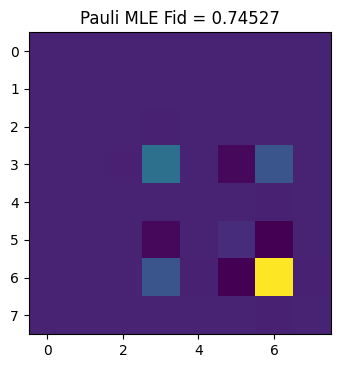

In [248]:
plt.figure(dpi=100)
plt.imshow(np.real(rho_fit))
plt.title(f"Pauli MLE Fid = {state_fidelity(rho_fit, target_state):.5f}")

In [249]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo2(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq', standard_weights=True)
    # Compute fidelity
    return rho_fit

In [250]:
rho_fit_tomo = state_tomo2(res_analysis['data'][14]['raw_data'], qcs[4])
# rho_fit_tomo = make_positive_semidefinite(rho_fit_tomo)
# rho_fit_tomo *= 1 / np.trace(rho_fit_tomo)

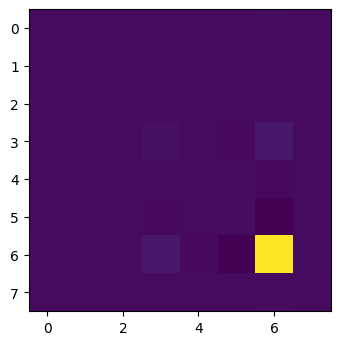

In [251]:
plt.figure(dpi=100)
plt.imshow(np.real(rho_fit_tomo))

In [252]:
state_fidelity(rho_fit_tomo, target_state)

0.9828593598983871

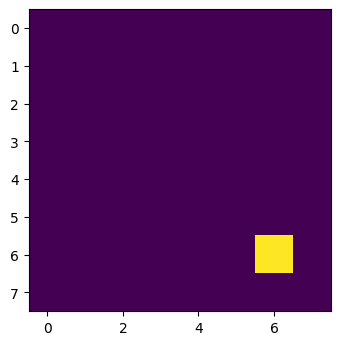

In [253]:
plt.figure(dpi=100)
plt.imshow(np.real(target_state))

### Probability/Count Fitting

In [254]:
from ast import literal_eval
from qiskit import QiskitError
from qiskit import QuantumCircuit
from qiskit.ignis.verification.tomography import marginal_counts, count_keys, combine_counts

In [255]:
ct_data = {}

for circuit in qcs[14]:
    counts = None
    for result in res_analysis["data"][14]["raw_data"]:
        counts = result.get_counts(circuit)
        
        # should be inside for loop to sum over results?
        if counts is None:
            raise QiskitError("Result for {} not found".format(circ.name))
        if isinstance(circuit, str):
            pauli_tup = literal_eval(circuit)
        elif isinstance(circuit, QuantumCircuit):
            pauli_tup = literal_eval(circuit.name)
        else:
            pauli_tup = circuit
        if pauli_tup in data:
            ct_data[pauli_tup] = combine_counts(data[pauli_tup], counts)
        else:
            ct_data[pauli_tup] = counts

In [256]:
from tomography import CustomTomographyFitter

In [257]:
ctf = CustomTomographyFitter(ct_data)

In [258]:
data, basis_matrix, weights = ctf._fitter_data(standard_weights=True, beta=0.5)

In [259]:
rho_fit_prob = ctf.fit(method='lstsq', trace=1)
rho_fit_prob = make_positive_semidefinite(rho_fit_prob)
rho_fit_prob *= 1 / np.trace(rho_fit_prob)

In [260]:
state_fidelity(rho_fit_prob, target_state)

0.9828593598983878

In [40]:
state_fidelity(rho_fit_prob, target_state)

0.9820631968267999

### Tomography v2
See notebook: https://github.com/epelaaez/QuantumLibrary/blob/master/challenges/QOSF%20Monthly/July%202021.ipynb
and blog: https://medium.com/quantum-untangled/quantum-state-tomography-4163d1df5a4d
Essentially another implementation of fitting Pauli exp. vals directly + making matrix PSD.

In [41]:
def mu_optimize(mu, n):
    # calculate eigenvalues of µ matrix
    eigen = np.linalg.eig(mu)
    vals  = eigen[0]
    vecs  = eigen[1].transpose()

    # order eigenvalues from largest to smallest
    eig_vals = sorted(vals, reverse=True)
    idx      = []
    for val in eig_vals:
        idx.append(np.where(vals == val)[0][0])
    eig_vecs = []
    for i in idx:
        eig_vecs.append(vecs[i])
        
    # calculate eigenvalues of the density matrix
    accumulator = 0
    lamb_vals   = [None] * len(eig_vals)
    for i in range(len(eig_vals) - 1, -1, -1):
        if eig_vals[i] + (accumulator / (i + 1)) >= 0:
            for j in range(i + 1):
                lamb_vals[j] = eig_vals[j] +  (accumulator / (i + 1))
            break
        else:
            lamb_vals[i] = 0
            accumulator  += eig_vals[i]

    # calculate density matrix
    predicted_state = np.zeros((2 ** n, 2 ** n), 'complex')
    for idx, lamb_val in enumerate(lamb_vals):
        predicted_state += lamb_vals[idx] * np.outer(eig_vecs[idx], eig_vecs[idx].conj())
    
    return predicted_state

def measurements_strings(n, arr=['X', 'Y', 'Z']):
    strs  = []
    combs = list(itertools.combinations_with_replacement(arr, n))
    for comb in combs:
        for item in set(list(itertools.permutations(comb))):
            strs.append("".join(item))
    return strs

def tensor_operator(arr):
    arr = list(arr)[::-1]
    
    I = np.array([[1, 0], [0, 1]])
    X = np.array([[0, 1], [1, 0]])
    Y  = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])
    
    first = arr.pop(0)
    if first == 'I':
        out = I
    elif first == 'X':
        out = X
    elif first == 'Y':
        out = Y
    else:
        out = Z
        
    for op in arr:
        if op == 'I':
            out = np.kron(out, I)
        elif op == 'X':
            out = np.kron(out, X)
        elif op == 'Y':
            out = np.kron(out, Y)
        else:
            out = np.kron(out, Z)

    return out.astype('complex')

In [42]:
target_parity = res_analysis["data"][14]["parity"]

In [43]:
# get all expectation values
ops      = measurements_strings(3, arr=['I', 'X', 'Y', 'Z'])[1:] # we need to consider identity operator here
exp_vals = []
for op in ops:
    exp_vals.append(target_parity[op])

# calculate µ matrix 
mu = tensor_operator(['I' for _ in range(3)])
for idx, op in enumerate(ops):
    mu += exp_vals[idx] * tensor_operator(op)
mu /= (2 ** 3)

# optimize the µ matrix to get the predicted density matrix
predicted_state = mu_optimize(mu, 3)

In [44]:
state_fidelity(predicted_state, target_state)

0.7443212510550661

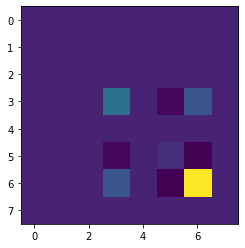

In [45]:
plt.imshow(np.real(predicted_state))

## Richardson ZNE with Mitiq

In [261]:
from mitiq import zne

In [ ]:
def executor(circuit, shots=10 ** 5):
    """Executes the input circuit and returns the noisy expectation value <A>, where A=|00>00|.
    """
    # Select a noisy backend
    # noisy_backend = qiskit.IBMQ.load_account().get_backend("ibmq_lima")
    noisy_backend = FakeLima() # Simulator with noise model similar to "ibmq_lima"

    # Append measurements
    circuit_to_run = circuit.copy()
    circuit_to_run.measure_all()

    # Run and get counts
    print(f"Executing circuit with {len(circuit)} gates using {shots} shots.")
    job = noisy_backend.run(circuit_to_run, shots=shots)
    counts = job.result().get_counts()

    # Compute expectation value of the observable A=|0><0|
    noisy_value = counts["00"] / shots
    return noisy_value

In [289]:
from trott import *

In [325]:
def executor(st_circuit, shots=8192, backend = sim_noisy_jakarta):
    shots = 8192
    reps = 8 #TODO: change back to 8

    # create jobs
    jobs = []
    for _ in range(reps):
        # execute
        job = execute(st_circuit, backend, shots=shots)
        print('Job ID', job.job_id())
        jobs.append(job)

    # monitor jobs
    for job in jobs:
        job_monitor(job)
        try:
            if job.error_message() is not None:
                print(job.error_message())
        except:
            pass
        
    # Average counts  
    avg_counts = {}
    for job in jobs:
        counts = job.result().get_counts()
        avg_counts = add_dicts(avg_counts, counts)
        
    pauli_string = extract_key(job.result().results[0].header.name)
    
    num_qubits = 3
    parsed_data = {}
    for active_spots in ACTIVE_LIST: # Loops through all possible parity measurements, e.g. [ZXY, ZXI, ZIY, IXY, ZII, IXI, IIY]
        for readout_string, count in avg_counts.items(): # loops through all readout values, e.g. '0x6', '0x2'
            adjusted_pauli_string, parity_meas = calc_parity_full(pauli_string, readout_string, active_spots) # ("ZXY", "0x6", (1,1,0)) -> "ZXI", 1 corresponds to <ZXI> = -1 measurement
            if adjusted_pauli_string not in parsed_data:
                parsed_data[adjusted_pauli_string] = [0,0] # [counts of 1, counts of -1]
            parsed_data[adjusted_pauli_string][parity_meas] += count

    parity = {}
    for parity_string, count in parsed_data.items():
        norm = np.sum(count)
        parity[parity_string] = (1)*count[0]/norm + (-1)*count[1]/norm
        
    return parity[pauli_string]

In [326]:
executor(qcs[4][0])

Job ID 7ff22f89-f6c0-45a6-844b-f0fda2cedacb
Job ID 6cf838be-77ca-4ff3-8692-d6080ca540ca
Job ID 9cd103c3-23ce-4f18-b097-298250c4fcb9
Job ID 381da7b2-2ce5-4bdb-bfa4-9816e50510fd
Job ID 61b613e6-4d69-413e-9102-c8776987e2a3
Job ID e10f3eac-211a-4521-8786-86c23c52b2cb
Job ID 0d7f82ae-5526-492f-8f75-f3a6151215c0
Job ID 763eb6af-fad4-4c81-9672-b68d8e49cc72
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


0.043975830078125

In [317]:
def mitiq_ZNE(tomography_circuits: List[QuantumCircuit]):
    
    for circuit in tomography_circuits:
        
        zne.execute_with_zne(circuit, executor)

In [327]:
zne.execute_with_zne(qcs[4][0], executor)

Job ID 8d12ab8e-3018-441f-9bbb-d528d86aa330
Job ID 4c57dd7e-e727-4b9d-9728-d1e4e796b05e
Job ID 9cf3ab28-9699-47a7-b135-d3e6605893f1
Job ID f0c33c35-999d-4db1-a054-c3c2d68d3208
Job ID 80809e69-ca78-4028-b04d-0490b11cbb86
Job ID 6f51aa2d-b402-4d7c-98f9-6d9005c1f805
Job ID eb19d946-d50d-47a5-930d-9aaa5646fbb1
Job ID 87cc3349-ce9d-404e-9f88-f60252590de7
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job ID 1117d8cf-a501-431c-89d7-64af39a755ee
Job ID 16b20673-5096-4914-83f4-82deebf518a6
Job ID 53cf2810-bf9d-4d1f-b145-4719b48089c8
Job ID e38a3f09-dfc2-484b-90f3-8f74b8770652
Job ID e1b58ee7-30d1-437f-94f6-3d63c924ada5
Job ID 8517a01d-938c-4f61-8242-c5d16c6062f5
Job ID c3952f12-8784-4d3d-a30d-76472cc3e6a5
Job ID 47f62779-4a7c-48c0-a076-c8532f1abb28


0.03302001953124998

In [328]:
from_qiskit(qcs[4][0])

q8643_1: ───────@──────────────@───Rx(0.5π)───@──────────────@───Rx(-0.5π)───Ry(0.5π)───@──────────────@───Ry(-0.5π)──────────────────────────────────────────────────────────────────────────────────────────────────────────@──────────────@───Rx(0.5π)───@──────────────@───Rx(-0.5π)───Ry(0.5π)───@──────────────@───Ry(-0.5π)──────────────────────────────────────────────────────────────────────────────────────────────────────────@──────────────@───Rx(0.5π)───@──────────────@───Rx(-0.5π)───Ry(0.5π)───@──────────────@───Ry(-0.5π)──────────────────────────────────────────────────────────────────────────────────────────────────────────@──────────────@───Rx(0.5π)───@──────────────@───Rx(-0.5π)───Ry(0.5π)───@──────────────@───Ry(-0.5π)───H───M('c12_0')────────────────────────────────────────────────────────────────────────────────────────────────────────────
                │              │              │              │                          │              │                                                                                                                      │              │              │              │                          │              │                                                                                                                      │              │              │              │                          │              │                                                                                                                      │              │              │              │                          │              │
q8643_3: ───X───X───Rz(0.5π)───X───Rx(0.5π)───X───Rz(0.5π)───X───Rx(-0.5π)───Ry(0.5π)───X───Rz(0.5π)───X───Ry(-0.5π)───@──────────────@───Rx(0.5π)───@──────────────@───Rx(-0.5π)───Ry(0.5π)───@──────────────@───Ry(-0.5π)───X───Rz(0.5π)───X───Rx(0.5π)───X───Rz(0.5π)───X───Rx(-0.5π)───Ry(0.5π)───X───Rz(0.5π)───X───Ry(-0.5π)───@──────────────@───Rx(0.5π)───@──────────────@───Rx(-0.5π)───Ry(0.5π)───@──────────────@───Ry(-0.5π)───X───Rz(0.5π)───X───Rx(0.5π)───X───Rz(0.5π)───X───Rx(-0.5π)───Ry(0.5π)───X───Rz(0.5π)───X───Ry(-0.5π)───@──────────────@───Rx(0.5π)───@──────────────@───Rx(-0.5π)───Ry(0.5π)───@──────────────@───Ry(-0.5π)───X───Rz(0.5π)───X───Rx(0.5π)───X───Rz(0.5π)───X───Rx(-0.5π)───Ry(0.5π)───X───Rz(0.5π)───X───Ry(-0.5π)───@────────────────@───Rx(0.5π)───@──────────────@───Rx(-0.5π)───Ry(0.5π)───@──────────────@───Ry(-0.5π)───H───M('c12_1')───
                                                                                                                       │              │              │              │                          │              │                                                                                                                      │              │              │              │                          │              │                                                                                                                      │              │              │              │                          │              │                                                                                                                      │                │              │              │                          │              │
q8643_5: ───X──────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(0.5π)───X───Rx(0.5π)───X───Rz(0.5π)───X───Rx(-0.5π)───Ry(0.5π)───X───Rz(0.5π)───X───Ry(-0.5π)──────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(0.5π)───X───Rx(0.5π)───X───Rz(0.5π)───X───Rx(-0.5π)───Ry(0.5π)───X───Rz(0.5π)───X───Ry(-0.5π)──────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(0.5π)───X───Rx(0.5π)───X───Rz(0.5π)───X───Rx(-0.5π)───Ry(0.5π)───X───Rz(0.5π)───X───Ry(-0.5π)──────────────────────────────────────────────────────────────────────────────────────────────────

In [148]:
from_qiskit(qcs[4][0].decompose().decompose().decompose().decompose())

QasmException: Unknown gate "u" at line 5

In [91]:
import cirq
from cirq.contrib.qasm_import import circuit_from_qasm
from qiskit import QuantumCircuit
from qiskit.extensions import Barrier

from mitiq.utils import _simplify_circuit_exponents


QASMType = str


def _remove_barriers(circuit: QuantumCircuit) -> QuantumCircuit:
    """Returns a copy of the input circuit with all barriers removed.

    Args:
        circuit: Qiskit circuit to remove barriers from.
    """
    copy = circuit.copy()
    for instr in copy.data:
        gate = instr[0]
        if isinstance(gate, Barrier):
            copy.data.remove(instr)
    return copy

def to_qiskit(circuit: cirq.Circuit) -> QuantumCircuit:
    """Returns a Qiskit circuit equivalent to the input Mitiq circuit.

    Args:
        circuit: Mitiq circuit to convert to a Qiskit circuit.

    Returns:
        Qiskit.QuantumCircuit object equivalent to the input Mitiq circuit.
    """
    return QuantumCircuit.from_qasm_str(to_qasm(circuit))



def from_qiskit(circuit: QuantumCircuit) -> cirq.Circuit:
    """Returns a Mitiq circuit equivalent to the input Qiskit circuit.

    Args:
        circuit: Qiskit circuit to convert to a Mitiq circuit.

    Returns:
        Mitiq circuit representation equivalent to the input Qiskit circuit.
    """
    return from_qasm(circuit.qasm())



def from_qasm(qasm: QASMType) -> cirq.Circuit:
    """Returns a Mitiq circuit equivalent to the input QASM string.

    Args:
        qasm: QASM string to convert to a Mitiq circuit.

    Returns:
        Mitiq circuit representation equivalent to the input QASM string.
    """
    qasm = _remove_barriers(QuantumCircuit.from_qasm_str(qasm)).qasm()
    return circuit_from_qasm(qasm)

In [141]:
print(qc_test.decompose().decompose().decompose().qasm())

OPENQASM 2.0;
include "qelib1.inc";
gate r(param0,param1) q0 { u3(pi/2,-pi/2,pi/2) q0; }
gate r_11503354544(param0,param1) q0 { u3(-pi/2,-pi/2,pi/2) q0; }
gate r_11503356128(param0,param1) q0 { u3(pi/2,0,0) q0; }
gate r_11503354304(param0,param1) q0 { u3(-pi/2,-pi/2,pi/2) q0; }
gate r_11503355744(param0,param1) q0 { u3(pi/2,0,0) q0; }
gate r_11503356848(param0,param1) q0 { u3(-pi/2,0,0) q0; }
gate r_11503354976(param0,param1) q0 { u3(-pi/2,0,0) q0; }
gate r_11503357760(param0,param1) q0 { u3(-pi/2,-pi/2,pi/2) q0; }
gate r_11503357568(param0,param1) q0 { u3(pi/2,0,0) q0; }
gate r_11503353920(param0,param1) q0 { u3(-pi/2,-pi/2,pi/2) q0; }
gate r_11503355984(param0,param1) q0 { u3(pi/2,0,0) q0; }
gate r_11503357712(param0,param1) q0 { u3(-pi/2,0,0) q0; }
gate r_11503355552(param0,param1) q0 { u3(-pi/2,-pi/2,pi/2) q0; }
gate r_11503357136(param0,param1) q0 { u3(pi/2,0,0) q0; }
gate r_11503356176(param0,param1) q0 { u3(-pi/2,-pi/2,pi/2) q0; }
gate r_11503356416(param0,param1) q0 { u3(pi/2,0

In [131]:
qc_test = gen_qc(trott_gate, 4)

In [133]:
qc_test.decompose().draw()

»
q8491_0: ─────────────────────────────────────────────────────────────»
                      ┌──────────┐┌──────────┐┌──────────┐            »
q8491_1: ─────────────┤0         ├┤0         ├┤0         ├────────────»
                      │          ││          ││          │            »
q8491_2: ─────────────┤  ZZ(π/4) ├┤  YY(π/4) ├┤  XX(π/4) ├────────────»
         ┌───────────┐│          ││          ││          │┌──────────┐»
q8491_3: ┤ U3(π,0,π) ├┤1         ├┤1         ├┤1         ├┤0         ├»
         └───────────┘└──────────┘└──────────┘└──────────┘│          │»
q8491_4: ─────────────────────────────────────────────────┤  ZZ(π/4) ├»
         ┌───────────┐                                    │          │»
q8491_5: ┤ U3(π,0,π) ├────────────────────────────────────┤1         ├»
         └───────────┘                                    └──────────┘»
q8491_6: ─────────────────────────────────────────────────────────────»
                                                                      »
«                                                                     »
«q8491_0: ────────────────────────────────────────────────────────────»
«                                 ┌──────────┐┌──────────┐┌──────────┐»
«q8491_1: ────────────────────────┤0         ├┤0         ├┤0         ├»
«                                 │          ││          ││          │»
«q8491_2: ────────────────────────┤  ZZ(π/4) ├┤  YY(π/4) ├┤  XX(π/4) ├»
«         ┌──────────┐┌──────────┐│          ││          ││          │»
«q8491_3: ┤0         ├┤0         ├┤1         ├┤1         ├┤1         ├»
«         │          ││          │└──────────┘└──────────┘└──────────┘»
«q8491_4: ┤  YY(π/4) ├┤  XX(π/4) ├────────────────────────────────────»
«         │          ││          │                                    »
«q8491_5: ┤1         ├┤1         ├────────────────────────────────────»
«         └──────────┘└──────────┘                                    »
«q8491_6: ────────────────────────────────────────────────────────────»
«                                                                     »
«                                                                     »
«q8491_0: ────────────────────────────────────────────────────────────»
«                                             ┌──────────┐┌──────────┐»
«q8491_1: ────────────────────────────────────┤0         ├┤0         ├»
«                                             │          ││          │»
«q8491_2: ────────────────────────────────────┤  ZZ(π/4) ├┤  YY(π/4) ├»
«         ┌──────────┐┌──────────┐┌──────────┐│          ││          │»
«q8491_3: ┤0         ├┤0         ├┤0         ├┤1         ├┤1         ├»
«         │          ││          ││          │└──────────┘└──────────┘»
«q8491_4: ┤  ZZ(π/4) ├┤  YY(π/4) ├┤  XX(π/4) ├────────────────────────»
«         │          ││          ││          │                        »
«q8491_5: ┤1         ├┤1         ├┤1         ├────────────────────────»
«         └──────────┘└──────────┘└──────────┘                        »
«q8491_6: ────────────────────────────────────────────────────────────»
«                                                                     »
«                                                                     »
«q8491_0: ────────────────────────────────────────────────────────────»
«         ┌──────────┐                                    ┌──────────┐»
«q8491_1: ┤0         ├────────────────────────────────────┤0         ├»
«         │          │                                    │          │»
«q8491_2: ┤  XX(π/4) ├────────────────────────────────────┤  ZZ(π/4) ├»
«         │          │┌──────────┐┌──────────┐┌──────────┐│          │»
«q8491_3: ┤1         ├┤0         ├┤0         ├┤0         ├┤1         ├»
«         └──────────┘│          ││          ││          │└──────────┘»
«q8491_4: ────────────┤  ZZ(π/4) ├┤  YY(π/4) ├┤  XX(π/4) ├────────────»
«                     │          ││          ││          │            »
«q8491_5: ────────────┤1         ├┤1  

In [134]:
from qiskit.compiler import transpile

In [139]:
transpile(qc_test).decompose().decompose().draw()

»
q8491_0: ─────────────────────────────────────────────────────────────────»
                                          ┌─────────┐                     »
q8491_1: ──────────────■───────────────■──┤ Rx(π/2) ├──■───────────────■──»
                       │               │  └─────────┘  │               │  »
q8491_2: ──────────────┼───────────────┼───────────────┼───────────────┼──»
         ┌──────────┐┌─┴─┐┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐»
q8491_3: ┤ U(π,0,π) ├┤ X ├┤ Rz(π/2) ├┤ X ├┤ Rx(π/2) ├┤ X ├┤ Rz(π/2) ├┤ X ├»
         └──────────┘└───┘└─────────┘└───┘└─────────┘└───┘└─────────┘└───┘»
q8491_4: ─────────────────────────────────────────────────────────────────»
         ┌──────────┐                                                     »
q8491_5: ┤ U(π,0,π) ├─────────────────────────────────────────────────────»
         └──────────┘                                                     »
q8491_6: ─────────────────────────────────────────────────────────────────»
                                                                          »
«                                                                      »
«q8491_0: ─────────────────────────────────────────────────────────────»
«         ┌──────────┐┌─────────┐                     ┌──────────┐     »
«q8491_1: ┤ Rx(-π/2) ├┤ Ry(π/2) ├──■───────────────■──┤ Ry(-π/2) ├─────»
«         └──────────┘└─────────┘  │               │  └──────────┘     »
«q8491_2: ─────────────────────────┼───────────────┼───────────────────»
«         ┌──────────┐┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐┌──────────┐     »
«q8491_3: ┤ Rx(-π/2) ├┤ Ry(π/2) ├┤ X ├┤ Rz(π/2) ├┤ X ├┤ Ry(-π/2) ├──■──»
«         └──────────┘└─────────┘└───┘└─────────┘└───┘└──────────┘  │  »
«q8491_4: ──────────────────────────────────────────────────────────┼──»
«                                                                 ┌─┴─┐»
«q8491_5: ────────────────────────────────────────────────────────┤ X ├»
«                                                                 └───┘»
«q8491_6: ─────────────────────────────────────────────────────────────»
«                                                                      »
«                                                                     »
«q8491_0: ────────────────────────────────────────────────────────────»
«                                                                     »
«q8491_1: ────────────────────────────────────────────────────────────»
«                                                                     »
«q8491_2: ────────────────────────────────────────────────────────────»
«                         ┌─────────┐                     ┌──────────┐»
«q8491_3: ─────────────■──┤ Rx(π/2) ├──■───────────────■──┤ Rx(-π/2) ├»
«                      │  └─────────┘  │               │  └──────────┘»
«q8491_4: ─────────────┼───────────────┼───────────────┼──────────────»
«         ┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐┌──────────┐»
«q8491_5: ┤ Rz(π/2) ├┤ X ├┤ Rx(π/2) ├┤ X ├┤ Rz(π/2) ├┤ X ├┤ Rx(-π/2) ├»
«         └─────────┘└───┘└─────────┘└───┘└─────────┘└───┘└──────────┘»
«q8491_6: ────────────────────────────────────────────────────────────»
«                                                                     »
«                                                                          »
«q8491_0: ─────────────────────────────────────────────────────────────────»
«                                                                          »
«q8491_1: ──────────────────────────────────────────────■───────────────■──»
«                                                       │               │  »
«q8491_2: ──────────────────────────────────────────────┼───────────────┼──»
«         ┌─────────┐                     ┌──────────┐┌─┴─┐┌─────────┐┌─┴─┐»
«q8491_3: ┤ Ry(π/2) ├──■───────────────■──┤ Ry(-π/2) ├┤ X ├┤ Rz(π/2) ├┤ X ├»
«         └─────────┘  │               │  └──────────┘└───┘└─────────┘└───┘»
«q8491_4: ─────────────┼───────────────┼──────────────────────────

In [175]:
qrt = QuantumRegister(1)
qct = QuantumCircuit(qrt)

#qct.u(0, 0, 0, 0)
qct.x(0)

qct.qasm()

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q8610[1];\nx q8610[0];\n'

In [179]:
# Mitiq Conversion
from_qiskit(qct)

q8610_0: ───X───

In [180]:
from_qiskit(qct.decompose())

q8610_0: ───cirq.circuits.qasm_output.QasmUGate(theta=1.0, phi=0.0, lmda=1.0)───

In [181]:
from_qiskit(qct.decompose().decompose())

QasmException: Unknown gate "u" at line 4

In [174]:
qc_test.decompose().decompose().draw()

»
q8491_0: ─────────────────────────────────────────────────────────────────»
                                          ┌─────────┐                     »
q8491_1: ──────────────■───────────────■──┤ Rx(π/2) ├──■───────────────■──»
                       │               │  └─────────┘  │               │  »
q8491_2: ──────────────┼───────────────┼───────────────┼───────────────┼──»
         ┌──────────┐┌─┴─┐┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐»
q8491_3: ┤ U(π,0,π) ├┤ X ├┤ Rz(π/2) ├┤ X ├┤ Rx(π/2) ├┤ X ├┤ Rz(π/2) ├┤ X ├»
         └──────────┘└───┘└─────────┘└───┘└─────────┘└───┘└─────────┘└───┘»
q8491_4: ─────────────────────────────────────────────────────────────────»
         ┌──────────┐                                                     »
q8491_5: ┤ U(π,0,π) ├─────────────────────────────────────────────────────»
         └──────────┘                                                     »
q8491_6: ─────────────────────────────────────────────────────────────────»
                                                                          »
«                                                                      »
«q8491_0: ─────────────────────────────────────────────────────────────»
«         ┌──────────┐┌─────────┐                     ┌──────────┐     »
«q8491_1: ┤ Rx(-π/2) ├┤ Ry(π/2) ├──■───────────────■──┤ Ry(-π/2) ├─────»
«         └──────────┘└─────────┘  │               │  └──────────┘     »
«q8491_2: ─────────────────────────┼───────────────┼───────────────────»
«         ┌──────────┐┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐┌──────────┐     »
«q8491_3: ┤ Rx(-π/2) ├┤ Ry(π/2) ├┤ X ├┤ Rz(π/2) ├┤ X ├┤ Ry(-π/2) ├──■──»
«         └──────────┘└─────────┘└───┘└─────────┘└───┘└──────────┘  │  »
«q8491_4: ──────────────────────────────────────────────────────────┼──»
«                                                                 ┌─┴─┐»
«q8491_5: ────────────────────────────────────────────────────────┤ X ├»
«                                                                 └───┘»
«q8491_6: ─────────────────────────────────────────────────────────────»
«                                                                      »
«                                                                     »
«q8491_0: ────────────────────────────────────────────────────────────»
«                                                                     »
«q8491_1: ────────────────────────────────────────────────────────────»
«                                                                     »
«q8491_2: ────────────────────────────────────────────────────────────»
«                         ┌─────────┐                     ┌──────────┐»
«q8491_3: ─────────────■──┤ Rx(π/2) ├──■───────────────■──┤ Rx(-π/2) ├»
«                      │  └─────────┘  │               │  └──────────┘»
«q8491_4: ─────────────┼───────────────┼───────────────┼──────────────»
«         ┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐┌──────────┐»
«q8491_5: ┤ Rz(π/2) ├┤ X ├┤ Rx(π/2) ├┤ X ├┤ Rz(π/2) ├┤ X ├┤ Rx(-π/2) ├»
«         └─────────┘└───┘└─────────┘└───┘└─────────┘└───┘└──────────┘»
«q8491_6: ────────────────────────────────────────────────────────────»
«                                                                     »
«                                                                          »
«q8491_0: ─────────────────────────────────────────────────────────────────»
«                                                                          »
«q8491_1: ──────────────────────────────────────────────■───────────────■──»
«                                                       │               │  »
«q8491_2: ──────────────────────────────────────────────┼───────────────┼──»
«         ┌─────────┐                     ┌──────────┐┌─┴─┐┌─────────┐┌─┴─┐»
«q8491_3: ┤ Ry(π/2) ├──■───────────────■──┤ Ry(-π/2) ├┤ X ├┤ Rz(π/2) ├┤ X ├»
«         └─────────┘  │               │  └──────────┘└───┘└─────────┘└───┘»
«q8491_4: ─────────────┼───────────────┼──────────────────────────

In [209]:
def gen_trott_gate_QASM():
    t = Parameter('t') # parameterize variable t
    
    # XX(t)
    XX_qr = QuantumRegister(2)
    XX_qc = QuantumCircuit(XX_qr, name='XX')

    XX_qc.ry(np.pi/2,[0,1])
    XX_qc.cnot(0,1)
    XX_qc.rz(2 * t, 1)
    XX_qc.cnot(0,1)
    XX_qc.ry(-np.pi/2,[0,1])

    # Convert custom quantum circuit into a gate
    XX = XX_qc.to_instruction()
    
    # YY(t)
    YY_qr = QuantumRegister(2)
    YY_qc = QuantumCircuit(YY_qr, name='YY')

    YY_qc.rx(np.pi/2,[0,1])
    YY_qc.cnot(0,1)
    YY_qc.rz(2 * t, 1)
    YY_qc.cnot(0,1)
    YY_qc.rx(-np.pi/2,[0,1])

    # Convert custom quantum circuit into a gate
    YY = YY_qc.to_instruction()

        
    # ZZ(t)
    ZZ_qr = QuantumRegister(2)
    ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

    ZZ_qc.cnot(0,1)
    ZZ_qc.rz(2 * t, 1)
    ZZ_qc.cnot(0,1)

    # Convert custom quantum circuit into a gate
    ZZ = ZZ_qc.to_instruction()
    
    num_qubits = 3

    Trott_qr = QuantumRegister(num_qubits)
    Trott_qc = QuantumCircuit(Trott_qr, name='Trot')

    for i in range(0, num_qubits - 1):
        Trott_qc.append(ZZ, [Trott_qr[i], Trott_qr[i+1]])
        Trott_qc.append(YY, [Trott_qr[i], Trott_qr[i+1]])
        Trott_qc.append(XX, [Trott_qr[i], Trott_qr[i+1]])    
    
    # Convert custom quantum circuit into a gate
    Trott_gate = Trott_qc.to_instruction()
    return Trott_gate


In [214]:
def gen_qcs_QASM(trott_gate: Instruction, trotter_steps: int):
    """
    Args:
        n (int): number of trotter steps
    """
    
    t = trott_gate.params[0] # assuming only t param
    
    target_time = np.pi
    
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    
    qc2 = QuantumCircuit(qr)
    
    qc.x([3,5]) # prepare init state |q5q3q1> = |110>
    
    for _ in range(trotter_steps):
        qc2.append(trott_gate, [qr[1], qr[3], qr[5]])
    
    qc = qc + qc2.decompose().decompose()
    
    qc = qc.bind_parameters({t: target_time/trotter_steps})
    
    #return qc
    st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])
    return st_qcs
    
    

In [215]:
trot_QASM = gen_trott_gate_QASM()

In [217]:
qctqasms = gen_qcs_QASM(trot_QASM, 4)

In [218]:
qctqasms

In [220]:
from_qiskit(qctqasms[0])

q8638_1: ───────@──────────────@───Rx(0.5π)───@──────────────@───Rx(-0.5π)───Ry(0.5π)───@──────────────@───Ry(-0.5π)──────────────────────────────────────────────────────────────────────────────────────────────────────────@──────────────@───Rx(0.5π)───@──────────────@───Rx(-0.5π)───Ry(0.5π)───@──────────────@───Ry(-0.5π)──────────────────────────────────────────────────────────────────────────────────────────────────────────@──────────────@───Rx(0.5π)───@──────────────@───Rx(-0.5π)───Ry(0.5π)───@──────────────@───Ry(-0.5π)──────────────────────────────────────────────────────────────────────────────────────────────────────────@──────────────@───Rx(0.5π)───@──────────────@───Rx(-0.5π)───Ry(0.5π)───@──────────────@───Ry(-0.5π)───H───M('c11_0')────────────────────────────────────────────────────────────────────────────────────────────────────────────
                │              │              │              │                          │              │                                                                                                                      │              │              │              │                          │              │                                                                                                                      │              │              │              │                          │              │                                                                                                                      │              │              │              │                          │              │
q8638_3: ───X───X───Rz(0.5π)───X───Rx(0.5π)───X───Rz(0.5π)───X───Rx(-0.5π)───Ry(0.5π)───X───Rz(0.5π)───X───Ry(-0.5π)───@──────────────@───Rx(0.5π)───@──────────────@───Rx(-0.5π)───Ry(0.5π)───@──────────────@───Ry(-0.5π)───X───Rz(0.5π)───X───Rx(0.5π)───X───Rz(0.5π)───X───Rx(-0.5π)───Ry(0.5π)───X───Rz(0.5π)───X───Ry(-0.5π)───@──────────────@───Rx(0.5π)───@──────────────@───Rx(-0.5π)───Ry(0.5π)───@──────────────@───Ry(-0.5π)───X───Rz(0.5π)───X───Rx(0.5π)───X───Rz(0.5π)───X───Rx(-0.5π)───Ry(0.5π)───X───Rz(0.5π)───X───Ry(-0.5π)───@──────────────@───Rx(0.5π)───@──────────────@───Rx(-0.5π)───Ry(0.5π)───@──────────────@───Ry(-0.5π)───X───Rz(0.5π)───X───Rx(0.5π)───X───Rz(0.5π)───X───Rx(-0.5π)───Ry(0.5π)───X───Rz(0.5π)───X───Ry(-0.5π)───@────────────────@───Rx(0.5π)───@──────────────@───Rx(-0.5π)───Ry(0.5π)───@──────────────@───Ry(-0.5π)───H───M('c11_1')───
                                                                                                                       │              │              │              │                          │              │                                                                                                                      │              │              │              │                          │              │                                                                                                                      │              │              │              │                          │              │                                                                                                                      │                │              │              │                          │              │
q8638_5: ───X──────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(0.5π)───X───Rx(0.5π)───X───Rz(0.5π)───X───Rx(-0.5π)───Ry(0.5π)───X───Rz(0.5π)───X───Ry(-0.5π)──────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(0.5π)───X───Rx(0.5π)───X───Rz(0.5π)───X───Rx(-0.5π)───Ry(0.5π)───X───Rz(0.5π)───X───Ry(-0.5π)──────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(0.5π)───X───Rx(0.5π)───X───Rz(0.5π)───X───Rx(-0.5π)───Ry(0.5π)───X───Rz(0.5π)───X───Ry(-0.5π)──────────────────────────────────────────────────────────────────────────────────────────────────